# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных:  
* Данные геологоразведки трёх регионов находятся в файлах:
    * geo_data_0.csv
    * geo_data_1.csv
    * geo_data_2.csv
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
df_0 = pd.read_csv('geo_data_0.csv')
display(df_0.head())
df_1 = pd.read_csv('geo_data_1.csv')
display(df_0.head())
df_2 = pd.read_csv('geo_data_2.csv')
display(df_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
display(df_0.info())
display(df_1.info())
display(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [4]:
display(df_0.describe())
display(df_1.describe())
display(df_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [5]:
display(df_0.duplicated().sum())
display(df_1.duplicated().sum())
display(df_2.duplicated().sum())

0

0

0

Тип данных в столбцах — строки и вещественные числа, пропуски и дубликаты отсутствуют, данные не имеют аномалий.

За ненадобностью удалим столбец id

In [6]:
df_0 = df_0.drop('id', axis=1)
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)

## Обучение и проверка модели

Изучим признаки на предмет корреляции

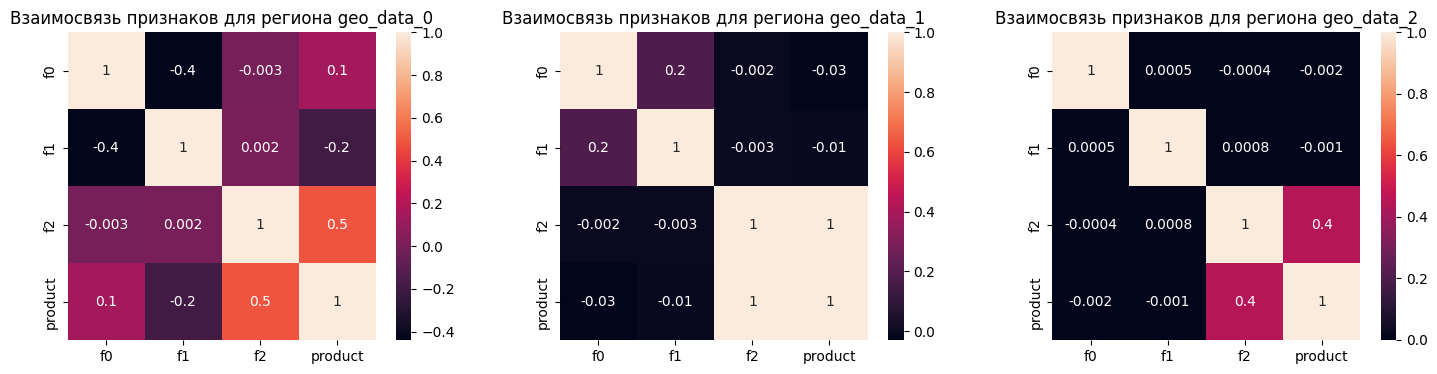

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(df_0.corr(), annot=True, fmt='.1g', square=True, ax=ax[0])
ax[0].set_title('Взаимосвязь признаков для региона geo_data_0')
sns.heatmap(df_1.corr(), annot=True, fmt='.1g', square=True, ax=ax[1])
ax[1].set_title('Взаимосвязь признаков для региона geo_data_1')
sns.heatmap(df_2.corr(), annot=True, fmt='.1g', square=True, ax=ax[2])
ax[2].set_title('Взаимосвязь признаков для региона geo_data_2')
plt.show()

Для региона geo_data_1 видим странное значение корреляции целевого признака от f2 равное единице. Значения же корреляции для регионов geo_data_0 и geo_data_2 похожи, зависмость не сильная, в наибольшей степени на целевой признак product влияет признак f2.

Разделим выборки на тренировочную и валидационную в соотношении 75/25

In [8]:
data = [df_0, df_1, df_2]
n = 0
for i in data:
    feature = i.drop('product', axis=1)
    target = i['product']
    feature_train, feature_valid, target_train, target_valid = train_test_split(feature, target, test_size=0.25, random_state=123)
    model = LinearRegression()
    model.fit(feature_train, target_train)
    prediction = model.predict(feature_valid)
    rmse = (mean_squared_error(target_valid, prediction))**0.5
    print('geo_data_' + str(n))
    n+= 1
    print('-'*50)
    print('rmse:', rmse)
    print('средний запас сырья в регионе:', prediction.mean())
    print('-'*50)


geo_data_0
--------------------------------------------------
rmse: 37.64786282376177
средний запас сырья в регионе: 92.54936189116309
--------------------------------------------------
geo_data_1
--------------------------------------------------
rmse: 0.8954139804944315
средний запас сырья в регионе: 69.28001860653976
--------------------------------------------------
geo_data_2
--------------------------------------------------
rmse: 40.12803006598514
средний запас сырья в регионе: 95.09859933591373
--------------------------------------------------


Наименьшую RMSE видим в регионе geo_data_1, но скорее всего такое значение обусловлено обнаруженными выше подозрительными значеними признака f2. Средний запас сырья больше всего в регионах geo_data_0 и geo_data_2, но значение RMSE здесь очень велико. Ошибка предсказания составляет практически более трети от среднего значения для geo_data_0 и почти 50% от среднего предсказанного значения для geo_data_2. Это высокий показатель ошибки.

## Подготовка к расчёту прибыли

Сохраним в отдельных переменных все ключевые значения для расчётов.

In [9]:
POINTS_NUM = 500       # общее число скважин для исследования
BEST_POINTS_NUM = 200  # число скважин в одном регионе для разработки
BUDGET = 10*(10**9)   # бюджет на разработку скважин в регионе
INCOME = 450000        # доход с каждой единицы продукта
RISK_MAX = 0.025       # максимальная вероятность убытков

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [10]:
budg_per_well = BUDGET / BEST_POINTS_NUM # Бюджет на 1-у скважину. Минимальный доход, который требуется от скважины, 
                                    # для достижения безубытка
    
min_volume_per_well = round((budg_per_well / INCOME), 6) # Минимальный объем сырья, который должна приносить скважина
                                                                        # для достижения безубытка

print("Минимальный доход, который должна приносить скважина:", budg_per_well, 'руб.')
print("Минимальный объем сырья, который должна приносить скважина:", min_volume_per_well, "тыс. барр.")

Минимальный доход, который должна приносить скважина: 50000000.0 руб.
Минимальный объем сырья, который должна приносить скважина: 111.111111 тыс. барр.


Согласно полученным выше значениям среднего запаса сырья по регионам, ни в одном регионе нет достаточного количества для безубыточной разработки, но по условию задачи нужно исследовать 500 скважин и выбрать 200 лучших. Для этого определим функцию income_calc

In [11]:
def income_calc(target, predicted):
    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)
    pred_sorted = predicted.sort_values(ascending=False)
    selected = target[pred_sorted.index][:BEST_POINTS_NUM]
    return INCOME * selected.sum() - BUDGET

In [12]:
def data(data):
    feature = data.drop('product', axis=1)
    target = data['product']
    feature_train, feature_valid, target_train, target_valid = train_test_split(feature, target, test_size=0.25, random_state=123)
    model = LinearRegression()
    model.fit(feature_train, target_train)
    prediction = model.predict(feature_valid)
    return target_valid, prediction

target_0, prediction_0 = data(df_0)
target_1, prediction_1 = data(df_1)
target_2, prediction_2 = data(df_2)

In [13]:
check = income_calc(target_0, prediction_0)
check

3534670917.261383

## Расчёт прибыли и рисков 

Для оценки рисков определим функцию bootstrap:

In [14]:
def bootstrap(target, prediction):
    state = np.random.RandomState(123)
    value = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=POINTS_NUM, replace=True, random_state = state)
        prediction = pd.Series(prediction)
        pred_subsample = prediction[target_subsample.index]
        res = income_calc(target_subsample, pred_subsample)
        value.append(res)
    value = pd.Series(value)
    
    lower = value.quantile(0.025)
    upper = value.quantile(0.975)
    mean = value.mean()
    risks = (value<0).mean()*100
    print('Средняя выручка:', round(mean/1000000), 'млн.р.')
    print('2.5%-квантиль:', round(lower/1000000), 'млн.р')
    print('Доверительный интервал:  от', round(lower/1000000), 'до', round(upper/1000000), 'млн.р')
    print('Bероятность убытков:', risks, '%')
        

In [15]:
print('Для региона geo_data_0:')
bootstrap(target_0, prediction_0)
print('--------------')
print('Для региона geo_data_1:')
bootstrap(target_1, prediction_1)
print('--------------')
print('Для региона geo_data_2:')
bootstrap(target_2, prediction_2)

Для региона geo_data_0:
Средняя выручка: 477 млн.р.
2.5%-квантиль: -58 млн.р
Доверительный интервал:  от -58 до 975 млн.р
Bероятность убытков: 4.1000000000000005 %
--------------
Для региона geo_data_1:
Средняя выручка: 479 млн.р.
2.5%-квантиль: 59 млн.р
Доверительный интервал:  от 59 до 874 млн.р
Bероятность убытков: 0.8999999999999999 %
--------------
Для региона geo_data_2:
Средняя выручка: 343 млн.р.
2.5%-квантиль: -231 млн.р
Доверительный интервал:  от -231 до 861 млн.р
Bероятность убытков: 9.9 %


Таким образом, в обозначенную границу вероятности убытков менее 2.5% попадает только регион geo_data_1. Также этот регион показывает наибольшую среднюю выручку в 479 млн.р. действительная прибыль будет лежать в диапазоне от 59 млн.р. до 874 млн. р. Риск получить убыток в данном регионе составляет 0.9%. Однако, стоит учитывать, что в этом регионе мы обнаружили необычное значение признака f2, сильно коррелирующее с объемом продукта.

### Общий вывод  
По итогам исследования для разработки рекомендуется регион geo_data_1:  

* вероятность убытков до 0.9%
* средняя выручка в 479 млн.р., наибольшее значение среди остальных регонов.
* диапазон прибыли от 59 млн.р. до 874 млн. р.